In [1]:
from gne.models.GeometricEmbedding import GeometricEmbedding, Config
from gne.utils.geometries import Euclidean
from gne.utils.complex import Simplex
from gne.utils.geometry_to_complex import kneighbors_complex

import torch
import matplotlib.pyplot as plt
import itertools

from umap import UMAP

In [2]:
# Global Variables
source_dimension = 10
k_neighbours = 4
batch_size = -1
n_points = 9

# Create Data

# Sample 1 (uniform random)
torch.manual_seed(42)
points = torch.rand(n_points, source_dimension)


In [3]:
# Calculate 2d projection of points into xy-plane
projection = points[:, [0, 1]]

In [4]:
# Calculate 2d PCA representation
_, _, V = torch.pca_lowrank(points)
principal_directions = V[:, :2]
principal_components = torch.matmul(points, principal_directions)
pca_embedding = principal_components

# Create kNN Complex of PCA
pca_geometry = Euclidean(sample=pca_embedding)
pca_complex = kneighbors_complex(pca_geometry, k_neighbours)

In [5]:
# Calculate umap Embedding
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42, n_jobs=1)
umap_embedding = umap_model.fit_transform(points)
umap_embedding = torch.tensor(umap_embedding)

# Create kNN Complex of umap
umap_geometry = Euclidean(sample=umap_embedding)
umap_complex = kneighbors_complex(umap_geometry, k_neighbours)

/home/micha/lin-projects/2024_gne/.venv/lib/python3.11/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [7]:
# Initialize gNE Embedding
# here: ~ 2 seconds/epoch, early stop at ~41 epochs -> 1.5min

# Set up GeometricEmbedding instance
djinni = GeometricEmbedding(
    source_geometry=Euclidean(sample=points),
    target_geometry=Euclidean(dimension=2),
    config=Config(epochs=100, k_neighbours=k_neighbours, batch_size=batch_size, learning_rate=1),
)

# get initial embedding for plotting
gne_embedding = djinni.target_geometry.sample.detach()

# create source_complex and target_complex for plotting
djinni.source_complex = kneighbors_complex(djinni.source_geometry, k_neighbours)
djinni.target_complex = kneighbors_complex(djinni.target_geometry, k_neighbours)

batch_size =  3


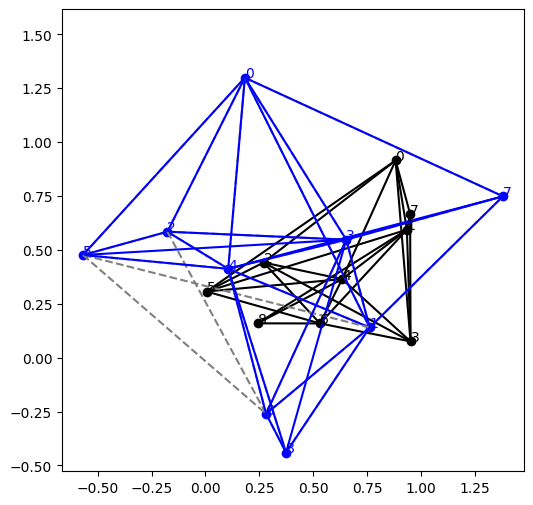

In [8]:
# Plot initial configuration
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(projection[:, 0], projection[:, 1], c='black')
for (i, p), (j, q) in itertools.combinations(enumerate(projection), 2):
    if Simplex([i,j]) in [s for s in djinni.source_complex if s.weight is not None]:
        ax.plot([p[0],q[0]], [p[1], q[1]], color='black')
for index, (x, y) in enumerate(projection):
    ax.annotate(str(index), (x, y), color='black', fontsize=10)

ax.scatter(gne_embedding[:, 0], gne_embedding[:, 1], c='blue')
for (i, p), (j, q) in itertools.combinations(enumerate(gne_embedding), 2):
    if Simplex([i,j]) in [s for s in djinni.source_complex if s.weight is not None]:
        ax.plot([p[0],q[0]], [p[1], q[1]], linestyle='dashed', color='grey')
    if Simplex([i,j]) in [s for s in djinni.target_complex if s.weight is not None]:
        ax.plot([p[0],q[0]], [p[1], q[1]], color='blue')
for index, (x, y) in enumerate(gne_embedding):
    ax.annotate(str(index), (x, y), color='blue', fontsize=10)
    
ax.set_aspect('equal')
ax.axis('square')

plt.show()

n_batches ~= 32.0


  0%|                                                                                                                                                       | 0/100 [00:00<?, ?it/s]/home/micha/lin-projects/2024_gne/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
loss: 55.616453766822815, delta: 7.109679698944092, threshold: 5.467681884765625, lr: 0.125, earlystop_count: 5:  41%|███████████▉                 | 41/100 [01:09<01:40,  1.70s/it]


Stopped at epoch 41
duration: 69.76 sec = 1.16 min


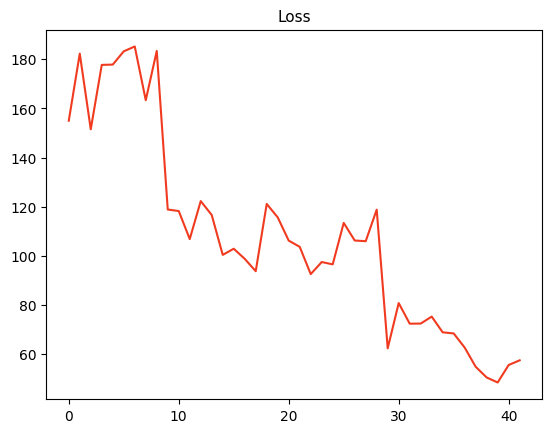

In [9]:
# Run Optimization

gne_embedding = djinni(plot_loss=True)

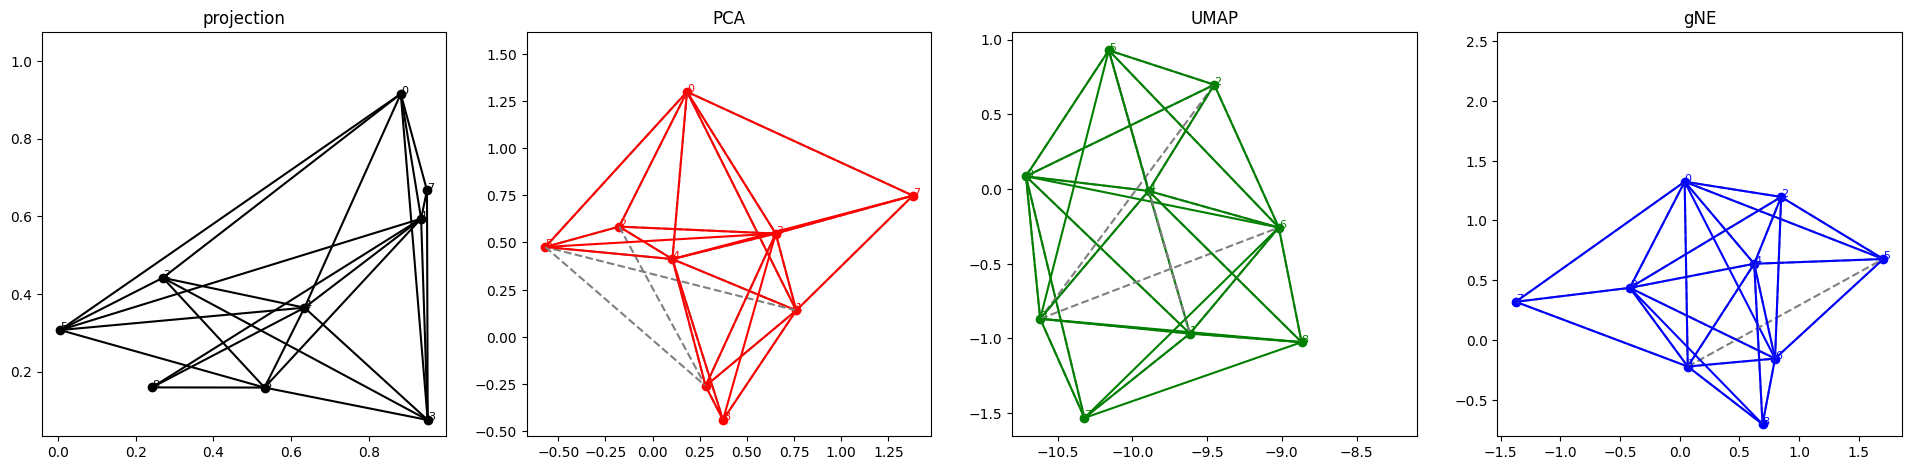

In [10]:
# Plot all 3 embeddings for direct comparison

fig, ax = plt.subplots(1, 4, figsize=(24, 6))

# projection
ax[0].set_title('projection')
ax[0].scatter(projection[:, 0], projection[:, 1], c='black')
for (i, p), (j, q) in itertools.combinations(enumerate(projection), 2):
    if Simplex([i,j]) in [s for s in djinni.source_complex if s.weight is not None]:
        ax[0].plot([p[0],q[0]], [p[1], q[1]], color='black')
for index, (x, y) in enumerate(projection):
    ax[0].annotate(str(index), (x, y), color='black', fontsize=8)


# PCA
ax[1].set_title('PCA')
ax[1].scatter(pca_embedding[:, 0], pca_embedding[:, 1], c='red')
for (i, p), (j, q) in itertools.combinations(enumerate(pca_embedding), 2):
    if Simplex([i,j]) in [s for s in djinni.source_complex if s.weight is not None]:
        ax[1].plot([p[0],q[0]], [p[1], q[1]], linestyle='dashed', color='grey')
    if Simplex([i,j]) in [s for s in pca_complex if s.weight is not None]:
        ax[1].plot([p[0],q[0]], [p[1], q[1]], color='red')
for index, (x, y) in enumerate(pca_embedding):
    ax[1].annotate(str(index), (x, y), color='red', fontsize=8)

# UMAP
ax[2].set_title('UMAP')
ax[2].scatter(umap_embedding[:, 0], umap_embedding[:, 1], c='green')
for (i, p), (j, q) in itertools.combinations(enumerate(umap_embedding), 2):
    if Simplex([i,j]) in [s for s in djinni.source_complex if s.weight is not None]:
        ax[2].plot([p[0],q[0]], [p[1], q[1]], linestyle='dashed', color='grey')
    if Simplex([i,j]) in [s for s in umap_complex if s.weight is not None]:
        ax[2].plot([p[0],q[0]], [p[1], q[1]], color='green')
for index, (x, y) in enumerate(umap_embedding):
    ax[2].annotate(str(index), (x, y), color='green', fontsize=8)

# gNE
ax[3].set_title('gNE')
ax[3].scatter(gne_embedding[:, 0], gne_embedding[:, 1], c='blue')
for (i, p), (j, q) in itertools.combinations(enumerate(gne_embedding), 2):
    if Simplex([i,j]) in [s for s in djinni.source_complex if s.weight is not None]:
        ax[3].plot([p[0],q[0]], [p[1], q[1]], linestyle='dashed', color='grey')
    if Simplex([i,j]) in [s for s in djinni.target_complex if s.weight is not None]:
        ax[3].plot([p[0],q[0]], [p[1], q[1]], color='blue')
for index, (x, y) in enumerate(gne_embedding):
    ax[3].annotate(str(index), (x, y), color='blue', fontsize=8)

for j in range(4):
    ax[j].set_aspect('equal')
    ax[j].axis('square')

plt.savefig('reports/figures/uniform-random.pdf')
plt.show()